In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('/content/NSE-TATAGLOBAL11.csv')

In [8]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [9]:
df.shape

(1235, 8)

In [10]:
df1=df.reset_index()['Close']

In [11]:
df1

0       215.15
1       209.20
2       218.20
3       227.60
4       230.90
         ...  
1230    159.45
1231    160.05
1232    160.15
1233    155.55
1234    155.80
Name: Close, Length: 1235, dtype: float64

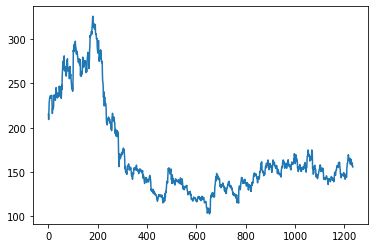

In [12]:
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [13]:
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1

array([[0.50425818],
       [0.47758853],
       [0.51792918],
       ...,
       [0.25773196],
       [0.2371134 ],
       [0.23823398]])

In [16]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [17]:
training_size,test_size

(802, 433)

In [18]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [20]:
print(X_train.shape), print(y_train.shape)

(701, 100)
(701,)


(None, None)

In [21]:
print(X_test.shape), print(ytest.shape)

(332, 100)
(332,)


(None, None)

In [22]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [23]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 7s 234ms/step - loss: 0.0423 - val_loss: 9.2361e-04
Epoch 2/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 3/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 4/100
11/11 [==============================] - 1s 132ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 5/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0029 - val_loss: 9.9522e-04
Epoch 6/100
11/11 [==============================] - 1s 131ms/step - loss: 0.0027 - val_loss: 9.4507e-04
Epoch 7/100
11/11 [==============================] - 1s 136ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0023 - val_loss: 9.0091e-04
Epoch 9/100
11/11 [==============================] - 1s 132ms/step - loss: 0.0023 - val_loss: 8.5087e-04
Epoch 10/100
11/11 [==============================] - 1s 134ms/step - l

In [27]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


176.0748106219564

In [30]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

150.99822974190562

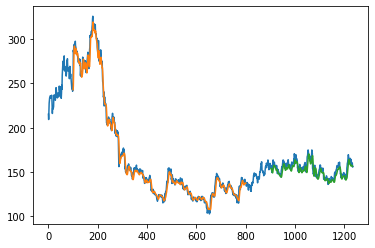

In [31]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)

433

In [34]:
x_input=test_data[333:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.23345794]
101
1 day input [0.16651726 0.17279247 0.17951591 0.17637831 0.17234424 0.16898252
 0.16831017 0.16248319 0.16987898 0.17525773 0.18556701 0.18915285
 0.18354998 0.1824294  0.17256835 0.18108472 0.18153294 0.17055132
 0.17189601 0.16943075 0.17705065 0.16270731 0.17346481 0.18646347
 0.20416853 0.21156432 0.20259973 0.20461676 0.19520394 0.20797848
 0.22142537 0.22142537 0.22523532 0.23890632 0.2447333  0.24406096
 0.24137158 0.24271627 0.24069924 0.23442403 0.25930076 0.25907665
 0.25616316 0.24831914 0.26176602 0.2447333  0.23330345 0.22613178
 0.20103093 0.20416853 0.18870462 0.18287763 0.19049753 0.19766921
 0.19878978 0.20080681 0.19744509 0.19520394 0.19722098 0.19229045
 0.19789332 0.20909906 0.20730614 0.20170327 0.19004931 0.19206634
 0.17817122 0.17548185 0.18377409 0.19139399 0.18780816 0.20192739
 0.18511878 0.18668758 0.23263111 0.2415957  0.25750784 0.25862842
 0.27297176 0.29112506 0.29964142 0.29157329 0.27498879 0.27947109
 0.26781712 0.27162707 0.27431645

In [44]:
len(df1)

1235

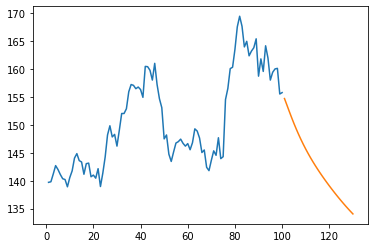

In [45]:
plt.plot(day_new,scaler.inverse_transform(df1[1135:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

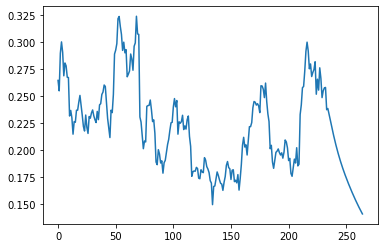

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])